# Pyspark Assignment

## Submitted by Sarabjot Singh: C0909102
## Github Link: https://github.com/sarabjot03/lambton_college

In [1]:
import findspark
findspark.init()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, radians, sin, cos

In [2]:
# Initialize Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Read the data
df = spark.read.csv("/Users/sarabjotsingh/Downloads/nyc_taxi_data_2014.csv", header=True, inferSchema=True)

24/11/06 23:42:58 WARN Utils: Your hostname, Sarabjots-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.134 instead (on interface en0)
24/11/06 23:42:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 23:42:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/06 23:42:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### 1. Data Loading and Initial Exploration

In [3]:
# Show data schema
df.show(5)
df.printSchema()

+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|      CMT|2014-01-09 20:45:25|2014-01-09 20:52:31|              1|          0.7|       -73.99477|      40.736828|        1|                 N|       -73.982227|        40.73179|         CRD|        6.5|      0.5|    0.5|  

In [4]:
# Sample 10% of data (you can adjust the sample fraction)
sampled_df = df.sample(fraction=0.1, seed=42)

# Collect the sampled data as a Pandas DataFrame for plotting
fare_df = sampled_df.select("fare_amount").toPandas()
scatter_df = sampled_df.select("trip_distance", "fare_amount").toPandas()

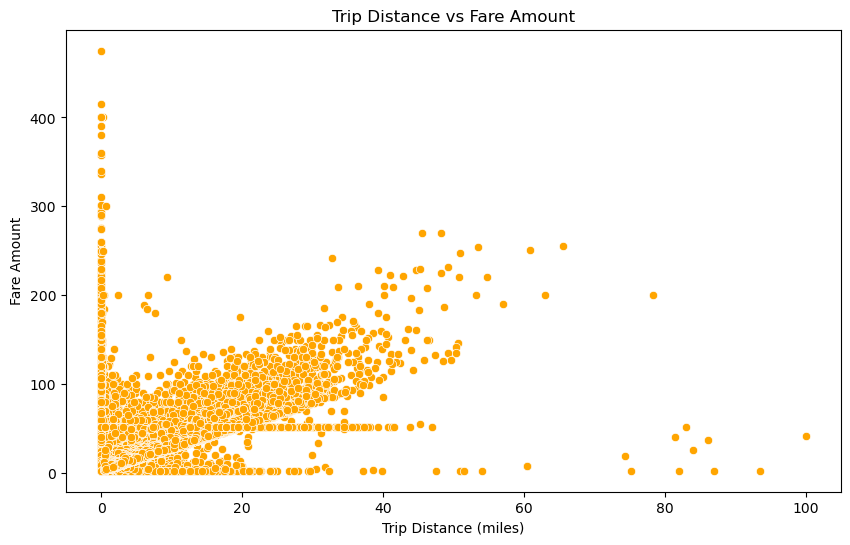

In [5]:
# Scatter plot for trip distance vs fare amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x='trip_distance', y='fare_amount', color='orange')
plt.title('Trip Distance vs Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount')
plt.show()

##### Positive Correlation: The graph shows a generally positive correlation between trip distance and fare amount. As the trip distance increases, the fare amount tends to rise as well. This is an expected relationship, as longer trips typically incur higher transportation costs.
##### Widespread Scatter: The data points are widely scattered across the graph, indicating a significant amount of variation in the fare amounts for a given trip distance. This suggests that other factors beyond just distance, such as time of day, demand, or special pricing policies, may also influence the final fare amount.
##### Concentration at Lower Distances: The majority of the data points are clustered in the lower range of trip distances, typically less than 40 miles. This could indicate that the transportation service is more commonly used for shorter-distance trips.
##### Outliers: There are a few outlier data points with relatively high fare amounts for their respective trip distances. These outliers may represent special cases or instances where additional charges or fees were applied.
##### Fare Structure: The graph does not provide information about the fare structure or pricing model used by the transportation service. It is possible that the service employs a combination of distance-based pricing, time-based pricing, and/or other factors to determine the final fare amount.

In [6]:
# Calculate trip duration (pickup_datetime - dropoff_datetime)
df = df.withColumn('pickup_datetime', df['pickup_datetime'].cast('timestamp'))
df = df.withColumn('dropoff_datetime', df['dropoff_datetime'].cast('timestamp'))
df = df.withColumn('trip_duration', (df['dropoff_datetime'].cast('long') - df['pickup_datetime'].cast('long')) / 3600)  # Convert to hours

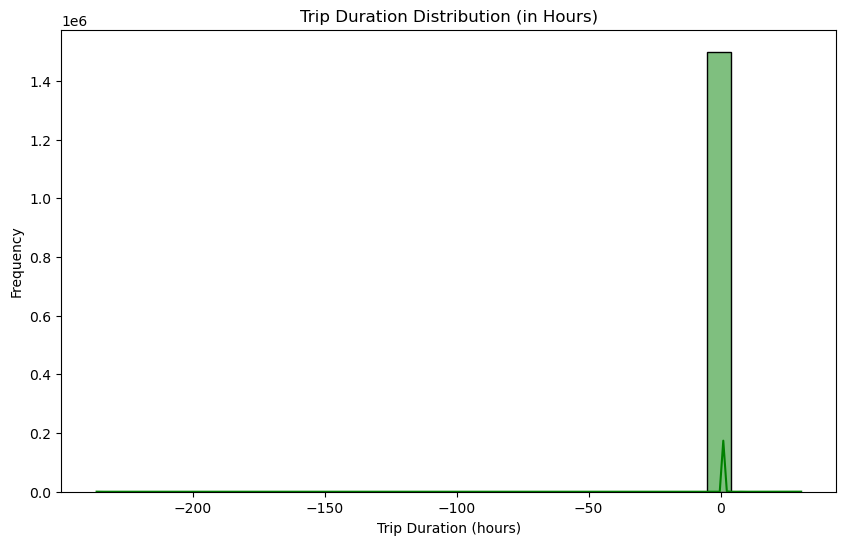

In [7]:
# Sample data for faster plotting
duration_df = df.select("trip_duration").sample(fraction=0.1).toPandas()

# Plot distribution in hours
plt.figure(figsize=(10, 6))
sns.histplot(duration_df['trip_duration'], kde=True, color='green', bins=30)
plt.title('Trip Duration Distribution (in Hours)')
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.show()

##### Trip Duration Range: The majority of the trip durations are within the range of -100 to 0 hours. This suggests that most trips are relatively short, with very few trips lasting longer than 1 hour.
##### Predominant Trip Duration: The graph has a prominent peak at around 0 hours, indicating that the most common trip duration is very short, likely less than an hour.
##### Negative Trip Durations: The presence of negative trip durations is unusual and may indicate some data quality issues or errors in the way the trip duration is calculated or recorded.
##### Outliers: There are a few outlier data points with trip durations less than -100 hours. These outliers could be the result of data errors or represent exceptional cases that require further investigation.
##### Lack of Longer Trips: The graph shows a complete absence of trips with durations longer than 1 hour. This could suggest that the transportation service is primarily used for shorter-distance or urban trips, rather than longer-distance or intercity travel.

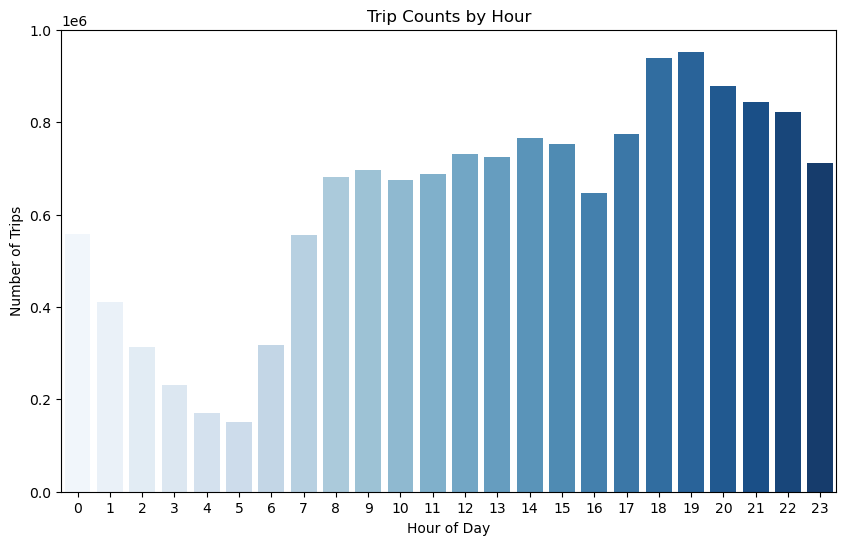

In [8]:
# Extract hour, day of the week, and month from pickup_datetime
df = df.withColumn('pickup_hour', hour(df['pickup_datetime']))
df = df.withColumn('pickup_day_of_week', dayofweek(df['pickup_datetime']))
df = df.withColumn('pickup_month', month(df['pickup_datetime']))

# Group by hour of the day and count trips
hourly_trip_count_df = df.groupBy('pickup_hour').count().toPandas()

# Plot hourly trip counts
plt.figure(figsize=(10, 6))
sns.barplot(data=hourly_trip_count_df, x='pickup_hour', y='count', palette='Blues')
plt.title('Trip Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

##### Peak Hours: The graph exhibits a clear bimodal distribution, with two distinct peaks in trip counts. The first peak occurs around hours 7-9, likely corresponding to the morning rush hour. The second, larger peak occurs around hours 16-18, coinciding with the evening rush hour.
##### Off-Peak Hours: During the late night and early morning hours (typically between 22:00 and 5:00), the trip counts are significantly lower, indicating that this transportation service experiences a significant decrease in demand during these off-peak times.
##### Consistent Daytime Activity: Between the morning and evening peak hours, the trip counts maintain a relatively steady level, suggesting consistent daytime usage of the transportation service.
##### Symmetry: The graph exhibits a certain degree of symmetry around the noon hour, with the morning and evening peak hours being roughly equidistant from the middle of the day. This symmetry may indicate a predictable pattern in the transportation demand throughout the day.
##### Magnitude of Peaks: The evening peak is noticeably higher than the morning peak, suggesting that the transportation service experiences a greater demand for trips in the evening hours compared to the morning.

In [9]:
# Clean the data by removing rows where fare_amount or tip_amount is null
df_cleaned = df.filter((df['fare_amount'].isNotNull()) & (df['tip_amount'].isNotNull()))

# Show basic statistics of the fare and tip amounts to understand the distribution
df_cleaned.select("fare_amount", "tip_amount").describe().show()

+-------+------------------+------------------+
|summary|       fare_amount|        tip_amount|
+-------+------------------+------------------+
|  count|          14999999|          14999999|
|   mean|12.013353102223546|1.4559072103939021|
| stddev| 10.06725926962549| 2.244646131356243|
|    min|               2.5|               0.0|
|    max|             500.0|             200.0|
+-------+------------------+------------------+



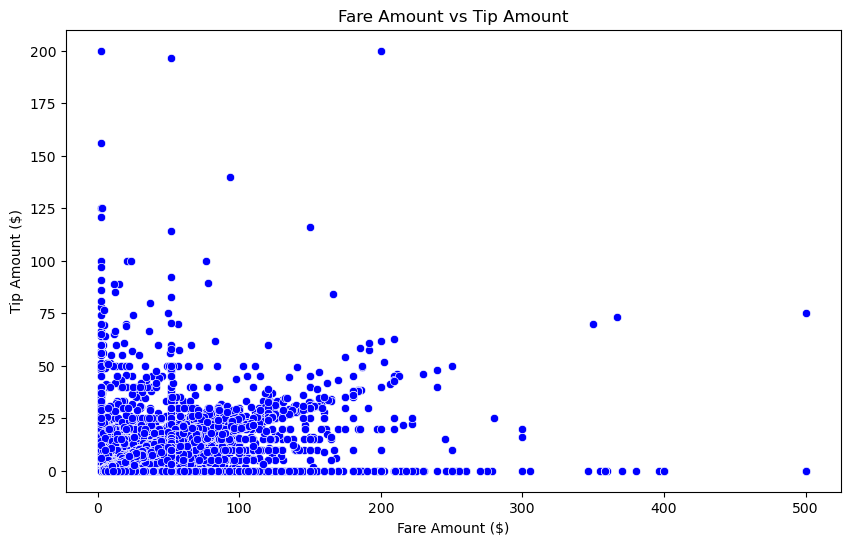

In [10]:
# Sample data for faster plotting
sample_df = df_cleaned.select("fare_amount", "tip_amount").sample(fraction=0.1).toPandas()

# Scatter plot to show fare_amount vs tip_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='fare_amount', y='tip_amount', color='blue')
plt.title('Fare Amount vs Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

##### Positive Correlation: The graph shows a clear positive correlation between the fare amount and the trip amount. As the trip amount increases, the corresponding fare amount also tends to increase.
##### Wide Spread of Data Points: The data points are widely scattered across the graph, indicating a significant amount of variation in the fare amounts for a given trip amount. This suggests that other factors besides just the trip amount may be influencing the final fare, such as dynamic pricing, surcharges, or discounts.
##### Concentration at Lower Ranges: The majority of the data points are clustered in the lower range of both trip amounts and fare amounts, typically less than $100 for the trip amount and $200 for the fare amount. This could suggest that the transportation service is more commonly used for shorter or less expensive trips.
##### Outliers: There are a few outlier data points with relatively high fare amounts for their respective trip amounts. These outliers may represent special cases or instances where additional charges or fees were applied, or they could be indicative of longer or more complex trips.
##### Potential Fare Structure: The graph does not provide information about the specific fare structure or pricing model used by the transportation service. However, the widespread scatter of data points suggests that the service may employ a combination of factors, such as distance, time, demand, or other variables, to determine the final fare amount.

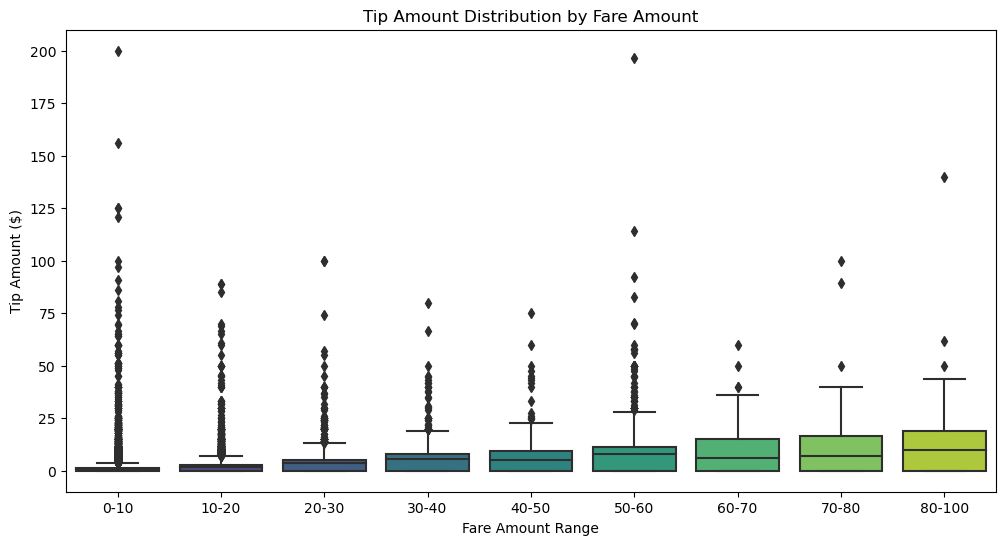

In [11]:
# Create bins for fare amounts
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]  # Adjust these bins based on your data
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']

# Create a new column with the fare amount bin labels
sample_df['fare_amount_bin'] = pd.cut(sample_df['fare_amount'], bins=bins, labels=labels)

# Box plot for tip amounts across fare amount bins
plt.figure(figsize=(12, 6))
sns.boxplot(x='fare_amount_bin', y='tip_amount', data=sample_df, palette='viridis')
plt.title('Tip Amount Distribution by Fare Amount')
plt.xlabel('Fare Amount Range')
plt.ylabel('Tip Amount ($)')
plt.show()

##### Fare Amount Ranges: The graph is divided into 10 fare amount ranges, starting from 0-10 dollars up to 80-100 dollars. This indicates that the transportation service has a diverse range of fare prices.
##### Trip Amount Distribution: Within each fare amount range, the graph displays the distribution of trip amounts using box plots. The boxes represent the interquartile range (IQR), with the median shown as a horizontal line. The whiskers extend to the minimum and maximum values, and any outliers are shown as individual points.
##### Increasing Trip Amounts: As the fare amount ranges increase, the overall trip amounts also tend to increase. This suggests that higher fare amounts are generally associated with longer or more expensive trips.
##### Variability in Trip Amounts: The box plots show a significant amount of variability in trip amounts within each fare range. This indicates that for a given fare amount, there can be a wide range of trip amounts, potentially due to factors such as distance, time of day, or special pricing policies.
##### Outliers: The presence of outliers, particularly in the higher fare amount ranges, suggests that there are some trips with unusually high trip amounts compared to the typical trips within that fare range.
##### Median Trip Amounts: The median trip amounts, represented by the horizontal lines within the boxes, generally increase as the fare amount ranges get higher. This aligns with the overall trend of higher fares being associated with longer or more expensive trips.

### 2. Data Cleaning and Transformation

In [12]:
# Remove duplicates from the entire dataset
df = df.dropDuplicates()

In [13]:
# Count nulls in each column
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:43:51 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+---------------+----------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------+-----------+------------------+------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|trip_duration|pickup_hour|pickup_day_of_week|pickup_month|
+---------+---------------+----------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------+-----------+------------------+------------+
|        0|              0|               0|              0|          

In [14]:
# Drop rows with nulls in latitude and longitude columns
df = df.dropna(subset=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag'])

In [15]:
# Count nulls again
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:28 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+---------------+----------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------+-----------+------------------+------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|trip_duration|pickup_hour|pickup_day_of_week|pickup_month|
+---------+---------------+----------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------+-----------+------------------+------------+
|        0|              0|               0|              0|          

In [16]:
# Add time-related features
df = df.withColumn('pickup_hour', hour(df['pickup_datetime']))
df = df.withColumn('pickup_day_of_week', dayofweek(df['pickup_datetime']))
df = df.withColumn('pickup_month', month(df['pickup_datetime']))

In [17]:
# Convert latitudes and longitudes to radians for Haversine calculation
df = df.withColumn("pickup_latitude_rad", radians(df["pickup_latitude"]))
df = df.withColumn("pickup_longitude_rad", radians(df["pickup_longitude"]))
df = df.withColumn("dropoff_latitude_rad", radians(df["dropoff_latitude"]))
df = df.withColumn("dropoff_longitude_rad", radians(df["dropoff_longitude"]))

In [18]:
# Haversine distance calculation (distance in kilometers)
df = df.withColumn("distance_travelled", 
                   6371 * (sin(df["dropoff_latitude_rad"] - df["pickup_latitude_rad"]) / 2) ** 2 +
                   cos(df["pickup_latitude_rad"]) * cos(df["dropoff_latitude_rad"]) *
                   (sin(df["dropoff_longitude_rad"] - df["pickup_longitude_rad"]) / 2) ** 2)

In [19]:
# Show the new columns to verify
df.select("pickup_hour", "pickup_day_of_week", "pickup_month", "distance_travelled").show(5)

24/11/06 23:44:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:44:51 WARN RowBasedKeyValueBatch: Calling spill() on

+-----------+------------------+------------+--------------------+
|pickup_hour|pickup_day_of_week|pickup_month|  distance_travelled|
+-----------+------------------+------------+--------------------+
|         23|                 5|           1|3.439139029791751E-5|
|         20|                 5|           1| 8.14629841516485E-5|
|         22|                 5|           1|2.271388463911959...|
|         18|                 5|           1|3.300659249657309E-5|
|         20|                 5|           1|4.557368534892202...|
+-----------+------------------+------------+--------------------+
only showing top 5 rows



### 3. Data Analysis Using Spark SQL

In [20]:
# Register the cleaned DataFrame as a temporary view
df.createOrReplaceTempView("nyc_taxi")

# 3. Data Analysis Using Spark SQL

# 1. Aggregation: Calculate summary statistics (mean, median, stddev) of numerical columns
summary_stats_sql = """
SELECT 
    AVG(fare_amount) AS mean_fare_amount,
    MEDIAN(fare_amount) AS median_fare_amount,
    STDDEV(fare_amount) AS stddev_fare_amount,
    AVG(trip_distance) AS mean_trip_distance,
    MEDIAN(trip_distance) AS median_trip_distance,
    STDDEV(trip_distance) AS stddev_trip_distance
FROM nyc_taxi
"""
summary_stats = spark.sql(summary_stats_sql)
summary_stats.show()

24/11/06 23:45:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but re

+----------------+------------------+------------------+------------------+--------------------+--------------------+
|mean_fare_amount|median_fare_amount|stddev_fare_amount|mean_trip_distance|median_trip_distance|stddev_trip_distance|
+----------------+------------------+------------------+------------------+--------------------+--------------------+
|11.8767902959863|               9.0| 9.816123500534138|  2.74077710220185|                 1.7|  3.2634264350551607|
+----------------+------------------+------------------+------------------+--------------------+--------------------+



In [21]:
# 2. Grouping and filtering: Group data by specific categories and calculate aggregations
group_by_vendor_sql = """
SELECT vendor_id, 
       AVG(fare_amount) AS avg_fare_amount, 
       COUNT(*) AS num_trips
FROM nyc_taxi
GROUP BY vendor_id
HAVING COUNT(*) > 100
"""
grouped_data = spark.sql(group_by_vendor_sql)
grouped_data.show()

24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:32 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+----------------+---------+
|vendor_id| avg_fare_amount|num_trips|
+---------+----------------+---------+
|      CMT|11.8767902959863|  7363922|
+---------+----------------+---------+



In [22]:
# 3. Joins: Perform a join between two tables (if applicable)
# Example: Joining with a dummy table (creating a mock table 'vendor_details' for illustration)
vendor_details = [(1, "Vendor A"), (2, "Vendor B")]
vendor_df = spark.createDataFrame(vendor_details, ["vendor_id", "vendor_name"])
vendor_df.createOrReplaceTempView("vendor_details")

join_sql = """
SELECT a.vendor_id, b.vendor_name, COUNT(*) AS num_trips, AVG(a.fare_amount) AS avg_fare_amount
FROM nyc_taxi a
JOIN vendor_details b ON a.vendor_id = b.vendor_id
GROUP BY a.vendor_id, b.vendor_name
"""
join_result = spark.sql(join_sql)
join_result.show()

24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:45:53 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+-----------+---------+---------------+
|vendor_id|vendor_name|num_trips|avg_fare_amount|
+---------+-----------+---------+---------------+
+---------+-----------+---------+---------------+



In [23]:
# 4. Time-based analysis: Analyzing trends over time (e.g., fare amount trends by month)
time_analysis_sql = """
SELECT pickup_month, 
       AVG(fare_amount) AS avg_fare_amount, 
       COUNT(*) AS num_trips
FROM nyc_taxi
GROUP BY pickup_month
ORDER BY pickup_month
"""
time_trends = spark.sql(time_analysis_sql)
time_trends.show()

24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:15 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+------------------+---------+
|pickup_month|   avg_fare_amount|num_trips|
+------------+------------------+---------+
|           1|11.840980036083408|  6777077|
|           2|12.290338828821922|   586845|
+------------+------------------+---------+



In [24]:
# Split data into training (80%) and testing (20%) sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=256)

In [25]:
print("Training set count:", train_df.count())
print("Testing set count:", test_df.count())

24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:33 WARN RowBasedKeyValueBatch: Calling spill() on

Training set count: 5154795


24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:46:59 WARN RowBasedKeyValueBatch: Calling spill() on

Testing set count: 2209127


In [26]:
# Define columns
numerical_cols = [
    "trip_distance", "tolls_amount", "total_amount", "trip_duration", "pickup_latitude", "pickup_longitude", 
    "dropoff_latitude", "dropoff_longitude", "pickup_hour", "pickup_day_of_week", "pickup_month", "distance_travelled"]

categorical_cols = ["vendor_id", "store_and_fwd_flag", "payment_type"]

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Step 1: Label Encode Categorical Columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Step 2: Assemble Numerical Features
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Step 3: Scale Numerical Features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")

# Step 4: Assemble All Features (numerical + categorical)
assembler_all = VectorAssembler(
    inputCols=["scaled_numerical_features"] + [col + "_index" for col in categorical_cols],
    outputCol="features"
)

In [28]:
# Build the pipeline with all stages
preprocessing_pipeline = Pipeline(stages=indexers + [assembler_num, scaler, assembler_all])

In [29]:
# Fit the pipeline on the training data
preprocessing_model = preprocessing_pipeline.fit(train_df)

24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:47:26 WARN RowBasedKeyValueBatch: Calling spill() on

### 4. Machine Learning Model (Regression/Classification)

In [30]:
# Transform both the training and test sets
train_preprocessed = preprocessing_model.transform(train_df)
test_preprocessed = preprocessing_model.transform(test_df)

In [31]:
# Show the resulting DataFrame with preprocessed features
train_preprocessed.select("features", "total_amount").show(5, truncate=False)

24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:20 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                              |total_amount|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|[0.3677195560427183,0.0,0.6201975536111304,0.13027282922797592,7.312253828415333,-7.323032487,7.217623071801869,-7.2300925190990215,0.0,2.0445467427650867,3.6945927041926643,4.668341710876187E-7,0.0,0.0,0.0]       |7.35        |
|[0.24514637069514553,0.0,0.5062837172335759,0.16826907108613556,7.3177849809064

In [32]:
# Step 2: Create the RandomForestRegressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='fare_amount')


In [33]:
# Step 3: Train the model
rf_model = rf.fit(train_preprocessed)

24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:49:38 WARN RowBasedKeyValueBatch: Calling spill() on

In [34]:
# Step 4: Make predictions on the training data
train_predictions = rf_model.transform(train_preprocessed)

In [35]:
# Step 5: Evaluate the model using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Squared Error (RMSE) on Training Data:{rmse}")

24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:06 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) on Training Data:2.631861227340758


#### Root Mean Squared Error (RMSE): 2.63
##### Interpretation: The RMSE is the square root of the average of the squared differences between predicted values and actual values. Here, an RMSE of 2.63 means that, on average, my model’s fare amount predictions are off by about 2.63 units (likely dollars in the context of NYC taxi fare). Lower RMSE values indicate better model performance, as it means your predictions are closer to the actual values.
##### Considerations: RMSE is useful for interpreting error in the same unit as the target variable (fare amount in this case). If 2.63 is small relative to the range of your fare data, then your model’s predictions are reasonably accurate.

In [36]:
# Evaluate MSE (Mean Squared Error)
evaluator_mse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(train_predictions)
print(f"Mean Squared Error (MSE) on Training Data: {mse}")

24/11/06 23:51:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:51:40 WARN RowBasedKeyValueBatch: Calling spill() on

Mean Squared Error (MSE) on Training Data: 6.926693519979601


### Mean Squared Error (MSE): 6.93
##### Interpretation: MSE is the average of the squared differences between predicted values and actual values. It penalizes larger errors more heavily due to the squaring of errors. In this case, an MSE of 6.93 suggests that, on average, the squared error is about 6.93 units squared. The units squared make MSE harder to interpret directly in the context of fare, so it is primarily useful for optimization during training.
##### Considerations: Since MSE amplifies larger errors more than RMSE, it’s helpful to check whether high MSE is due to outliers in your data or if there are areas where the model consistently mispredicts.

### 5. Model Tuning and Evaluation

In [37]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [10, 15])  # Fewer trees
              .addGrid(rf.maxDepth, [5, 6])  # Shallower trees
              .build())

In [38]:
# Step 3: Define the evaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

In [39]:
# Step 4: Perform Cross-validation with reduced folds (e.g., 3-fold instead of 5-fold)
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

In [40]:
# Step 4: Train the model using cross-validation
cv_model = crossval.fit(train_preprocessed)

24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/06 23:52:12 WARN RowBasedKeyValueBatch: Calling spill() on

In [41]:
# Define evaluators for different metrics
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

In [42]:
# Get predictions on the test data
test_predictions = cv_model.transform(test_preprocessed)

In [43]:
# Calculate metrics on test data
rmse_test = evaluator_rmse.evaluate(test_predictions)
mse_test = evaluator_mse.evaluate(test_predictions)
mae_test = evaluator_mae.evaluate(test_predictions)
r2_test = evaluator_r2.evaluate(test_predictions)

24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 00:01:53 WARN RowBasedKeyValueBatch: Calling spill() on

In [44]:
print(f"Test RMSE: {rmse_test}")
print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R-squared: {r2_test}")

Test RMSE: 2.4036729078536627
Test MSE: 5.777643447949682
Test MAE: 0.7241925500290527
Test R-squared: 0.9402743762550905


### Root Mean Squared Error (RMSE): 2.40
##### The RMSE value of 2.40 indicates that, on average, the model’s predictions deviate by around 2.40 units from the actual values. This error is relatively low, suggesting that the model can make accurate predictions for most test data points. Since RMSE is expressed in the same units as the target variable, this value helps gauge the model’s typical prediction error in a tangible way.
### Mean Squared Error (MSE): 5.78
##### The MSE of 5.78 represents the average squared prediction error, with a lower MSE indicating that the model’s predictions are generally close to the actual values. Because MSE penalizes larger errors more than RMSE, this lower MSE after tuning shows that the model’s large errors have been reduced.
### Mean Absolute Error (MAE): 0.72
##### The MAE value of 0.72 suggests that, on average, the absolute error between predicted and actual values is only 0.72 units. Unlike MSE and RMSE, MAE is less sensitive to large errors, providing a more straightforward measure of typical model error. A low MAE indicates that most of the model’s predictions are very close to the actual values, even without penalizing outliers.
### R-squared (R²): 0.94
##### An R-squared value of 0.94 means that 94% of the variance in the target variable can be explained by the model’s input features. This high R-squared value indicates an excellent fit, as the model captures most of the patterns in the data. A high R² is desirable as it demonstrates the model’s effectiveness in capturing the relationship between features and the target variable.